In [1]:
import pandas as pd
import numpy as np
import os
from scipy.stats import hypergeom
from matplotlib import pyplot as plt
from umap import UMAP
from sklearn.preprocessing import robust_scale
from hdbscan import HDBSCAN
import sys
import seaborn as sns
sys.path.insert(0, '../../')
sys.path.insert(0, '../../cycif/')
from get_data import file2frame
from cycif import *
from common_apis import *

In [ ]:
# Define intermediate file location
os.chdir('d:/data/results')
pooled_expr_files = [x for x in os.listdir() if ('pooled data' in x) & ('Umap' not in x)]
metadata = pd.read_csv('MCF10A commons syn14734328 pooled metadata.csv',index_col=0)

In [2]:
# Load data from 0907 data
os.chdir('D:/data/MCF10A 090718 data/')
if not os.path.exists('Results'):
    os.mkdir('Results')
pooled_expr_data = pd.read_csv('MCF10A 090718 pooled data normalized.csv',index_col=0)
pooled_metadata = pd.read_csv('MCF10A 090718 pooled metadata.csv',index_col=0)
pooled_metadata = pooled_metadata[pooled_metadata.ligand!='ControlT0']

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'D:/data/MCF10A 090718 data/'

In [61]:
batch_normed = pd.DataFrame()
for plate in pooled_metadata.Plate.unique():
    cells = pooled_metadata[pooled_metadata.Plate==plate].index
    df_plate = pooled_expr_data.loc[cells]
    scaled = robust_scale(df_plate,quantile_range=(1,99))
    scaled[scaled<=-1] = -1
    scaled[scaled>=1] = 1
#     scaled = df_plate.apply(lambda x: x-x.median())
#     scaled = df_plate.apply(lambda x: x-x.quantile(0.75))
    scaled = pd.DataFrame(scaled,index=df_plate.index,columns=df_plate.columns)
    batch_normed = batch_normed.append(scaled)

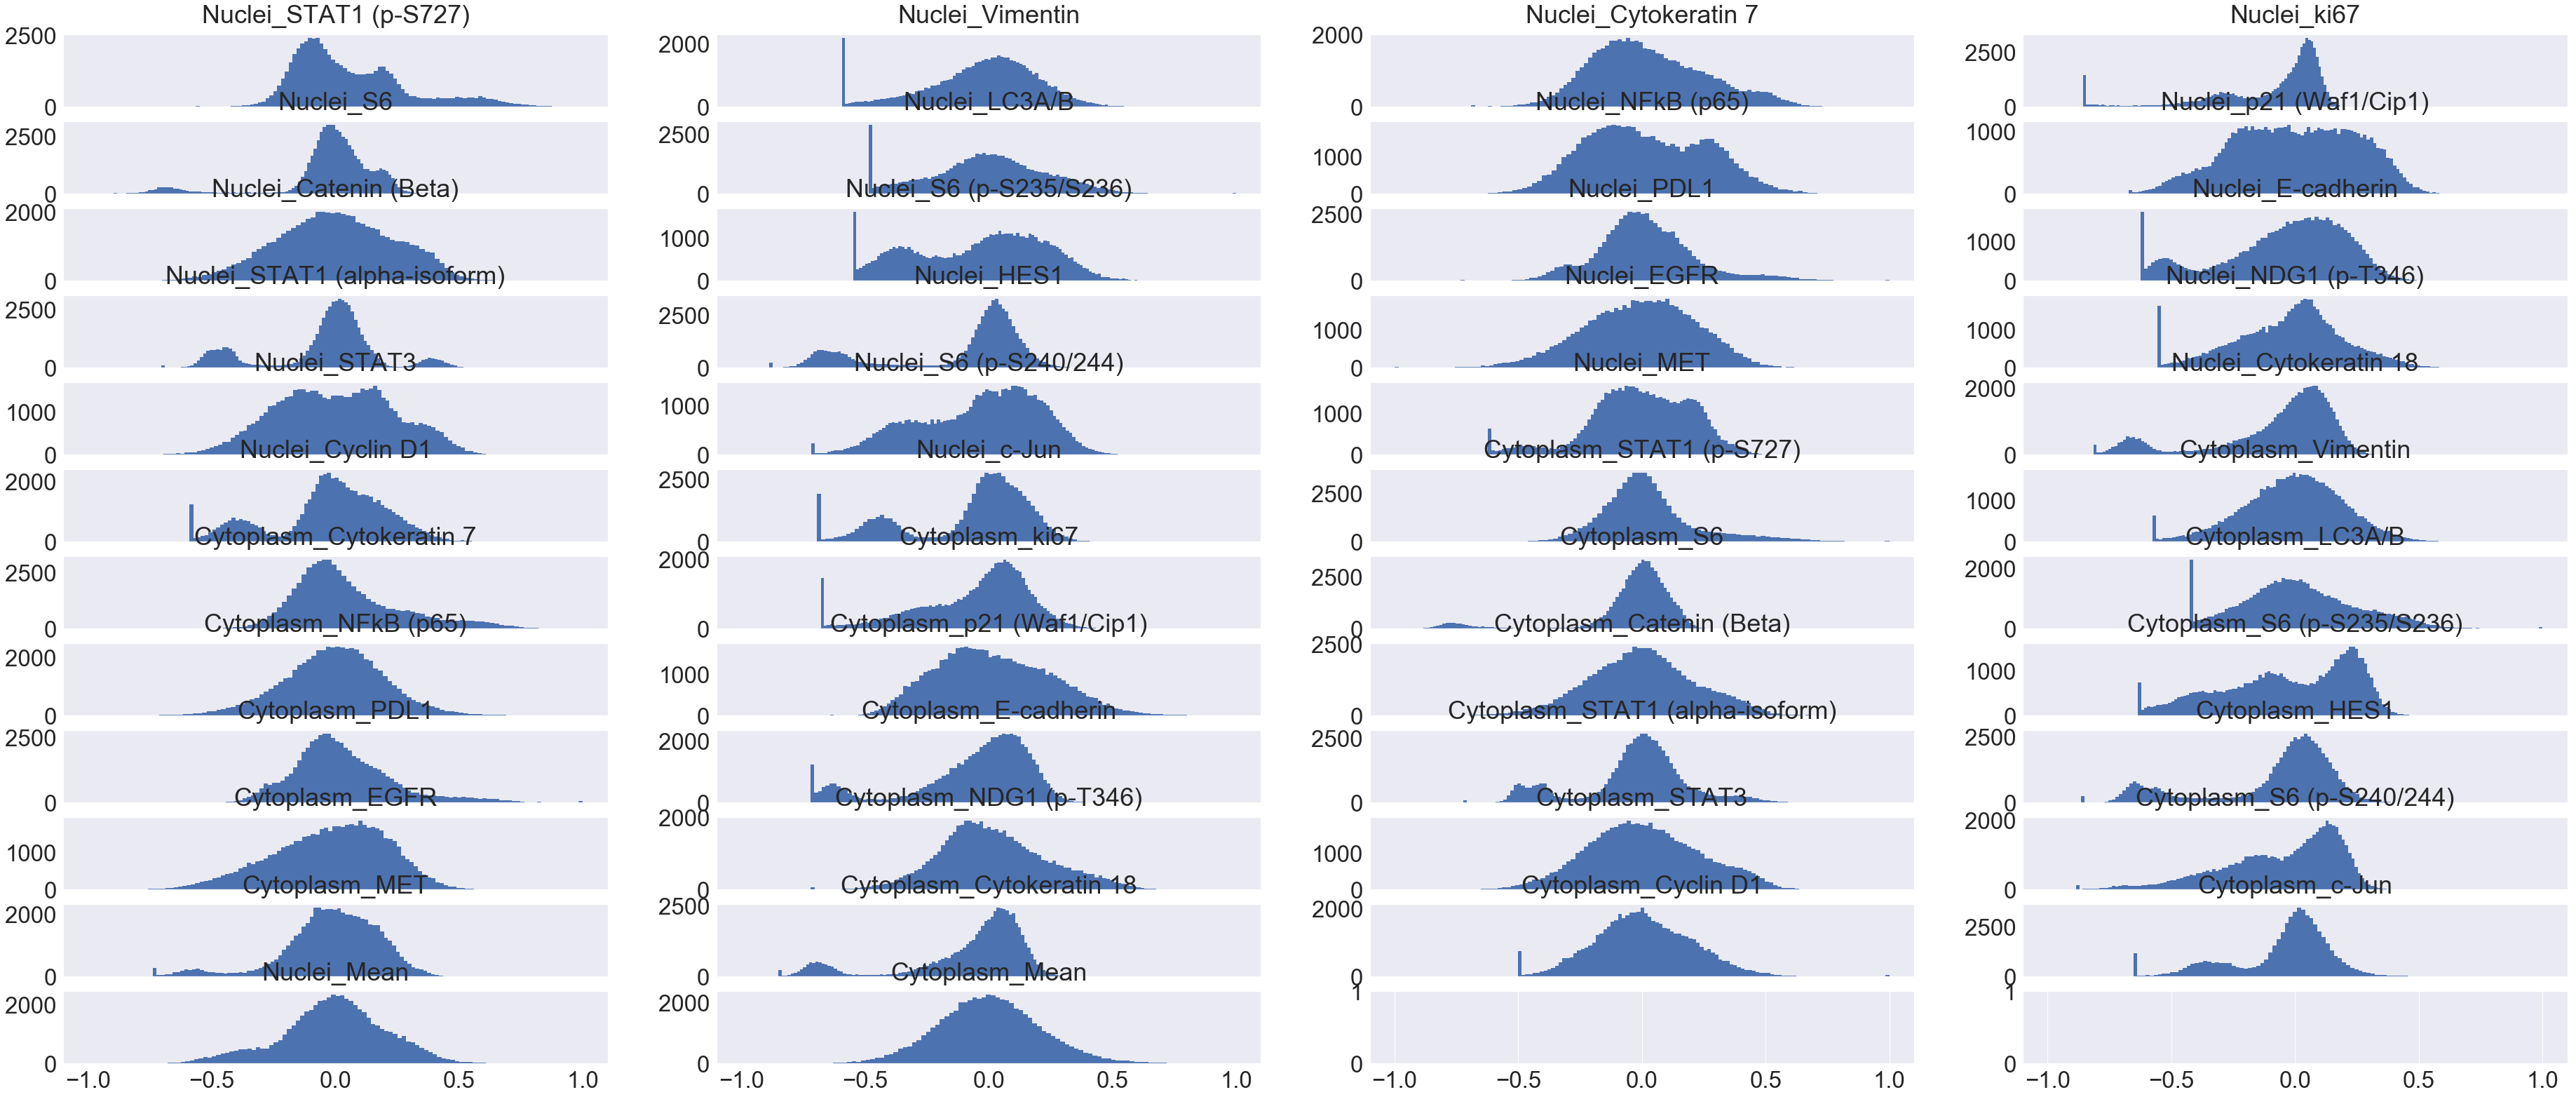

In [55]:
channel_histograms(scaled)

In [63]:
cells = pooled_metadata[pooled_metadata.time == 24].index
test_data = pooled_expr_data.loc[cells]
batch = pooled_metadata.loc[cells,'Plate'].values.tolist()
test_data['batch'] = batch
test_data.to_csv('d:/test_combat')

In [66]:
batch_normed = pd.read_csv('d:/test_combat.csv',index_col=0).transpose()
batch_normed.head()

,Nuclei_STAT1..p.S727.,Nuclei_Vimentin,Nuclei_Cytokeratin.7,Nuclei_ki67,Nuclei_S6,Nuclei_LC3A.B,Nuclei_NFkB..p65.,Nuclei_p21..Waf1.Cip1.,Nuclei_Catenin..Beta.,Nuclei_S6..p.S235.S236.,...,Cytoplasm_EGFR,Cytoplasm_NDG1..p.T346.,Cytoplasm_STAT3,Cytoplasm_S6..p.S240.244.,Cytoplasm_MET,Cytoplasm_Cytokeratin.18,Cytoplasm_Cyclin.D1,Cytoplasm_c.Jun,Nuclei_Mean,Cytoplasm_Mean
Cell_57983,3.948954,3.369184,7.932406,11.920649,9.526649,3.005268,7.278033,4.817826,8.293670,4.004754,...,7.989131,4.890250,9.355183,7.886886,5.816950,9.378431,4.660931,5.533111,12.513373,10.498876
Cell_57984,5.163549,4.516038,6.614812,11.788033,10.863057,3.687941,8.670820,5.267675,8.183952,7.208985,...,8.325039,7.194311,8.920500,8.983708,5.830595,9.122920,3.671648,4.862362,13.073352,9.319712
Cell_57985,4.891176,2.550513,6.426826,10.712234,10.201430,2.906788,8.077428,2.304268,8.505883,7.055810,...,8.557395,6.025964,8.678375,9.539039,6.454283,8.770145,3.539783,8.321905,12.437143,8.982544
Cell_57986,3.522185,3.910887,4.084988,11.238217,8.879568,1.995416,6.647546,1.924898,5.373685,3.513483,...,7.818207,7.481543,7.323161,8.050591,5.393411,8.158870,3.768289,4.312180,12.520027,9.131054
Cell_57987,3.497449,3.877519,4.230140,11.005197,8.885464,1.333399,6.374499,3.762744,5.148787,6.670408,...,8.030731,5.726219,8.285463,9.391249,4.698152,8.834053,3.138760,4.807316,12.551013,9.548113


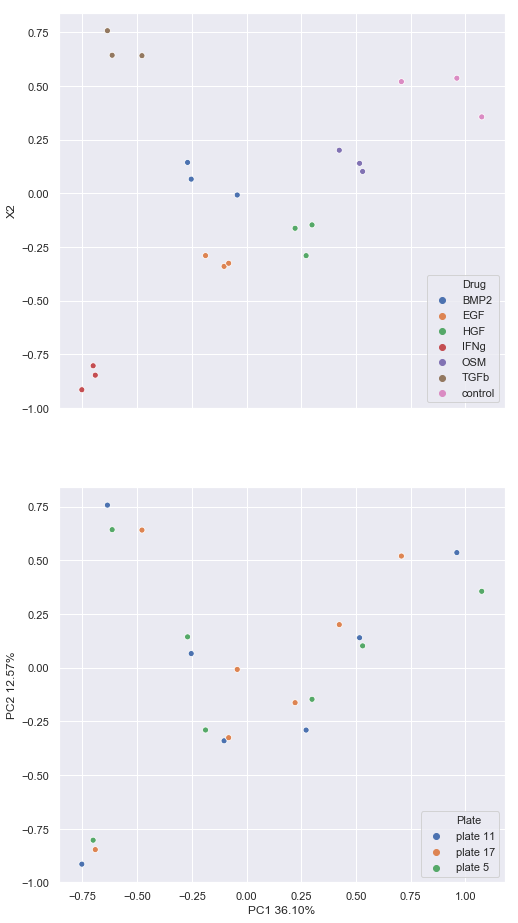

In [67]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import robust_scale
pooled_metadata['plate_condition'] = pooled_metadata.Plate.astype(str)+'_'+pooled_metadata.condition
pca = PCA(n_components=2,whiten=True)
umap = UMAP()

for time in pooled_metadata.time.unique():
    if time != 24:
        continue
    cells = pooled_metadata[pooled_metadata.time==time].index
    df_sub = batch_normed.loc[cells]
    cols = df_sub.columns
#     df_sub = robust_scale(df_sub,quantile_range = (1,99))
    df_sub = pd.DataFrame(df_sub,columns=cols)
    pca_data = pca.fit_transform(df_sub)
#     pca_data = umap.fit_transform(df_sub)
    pca.fit(df_sub)
    var_ratio = pca.explained_variance_ratio_
    pca_data = pd.DataFrame(pca_data)
    pca_data['group'] = pooled_metadata.loc[cells,'plate_condition'].values
    pca_data = pca_data.groupby('group').mean()
    pca_data['Drug'] = [x.split('_')[1] for x in pca_data.index]
    pca_data['Plate'] = ['plate ' + x.split('_')[0] for x in pca_data.index]
    pca_data.columns = ['X1','X2','Drug','Plate']
    _,axes = plt.subplots(2,sharex=True,figsize = (8,16))
    g = sns.scatterplot('X1','X2',data=pca_data,hue='Drug',hue_order=sorted(pca_data.Drug.unique()),ax=axes[0])
    g = sns.scatterplot('X1','X2',data=pca_data,hue='Plate',ax=axes[1])
    g.set_xlabel(('PC1 {:.2f}%').format(100*var_ratio[0]))
    g.set_ylabel(('PC2 {:.2f}%').format(100*var_ratio[1]))

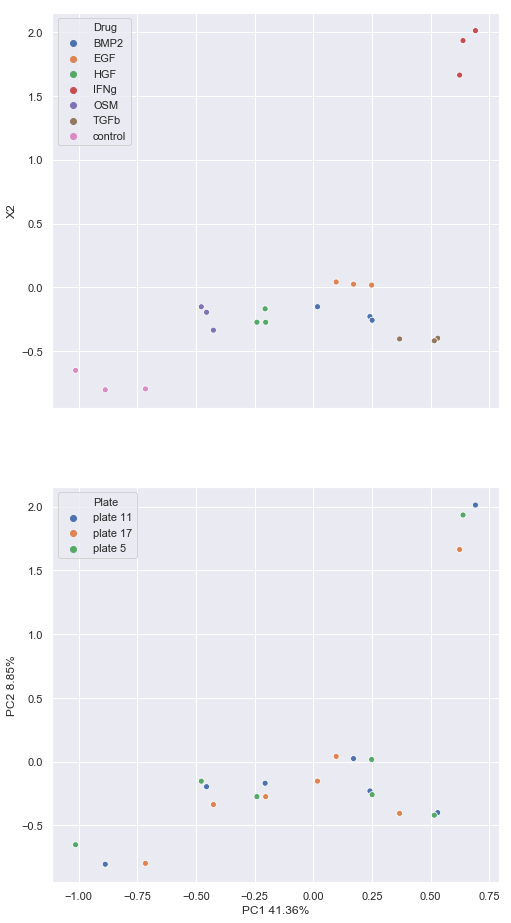

In [62]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import robust_scale
pooled_metadata['plate_condition'] = pooled_metadata.Plate.astype(str)+'_'+pooled_metadata.condition
pca = PCA(n_components=2,whiten=True)
umap = UMAP()

for time in pooled_metadata.time.unique():
    if time != 24:
        continue
    cells = pooled_metadata[pooled_metadata.time==time].index
    df_sub = batch_normed.loc[cells]
    cols = df_sub.columns
#     df_sub = robust_scale(df_sub,quantile_range = (1,99))
    df_sub = pd.DataFrame(df_sub,columns=cols)
    pca_data = pca.fit_transform(df_sub)
#     pca_data = umap.fit_transform(df_sub)
    pca.fit(df_sub)
    var_ratio = pca.explained_variance_ratio_
    pca_data = pd.DataFrame(pca_data)
    pca_data['group'] = pooled_metadata.loc[cells,'plate_condition'].values
    pca_data = pca_data.groupby('group').mean()
    pca_data['Drug'] = [x.split('_')[1] for x in pca_data.index]
    pca_data['Plate'] = ['plate ' + x.split('_')[0] for x in pca_data.index]
    pca_data.columns = ['X1','X2','Drug','Plate']
    _,axes = plt.subplots(2,sharex=True,figsize = (8,16))
    g = sns.scatterplot('X1','X2',data=pca_data,hue='Drug',hue_order=sorted(pca_data.Drug.unique()),ax=axes[0])
    g = sns.scatterplot('X1','X2',data=pca_data,hue='Plate',ax=axes[1])
    g.set_xlabel(('PC1 {:.2f}%').format(100*var_ratio[0]))
    g.set_ylabel(('PC2 {:.2f}%').format(100*var_ratio[1]))

In [ ]:
from sklearn.preprocessing import robust_scale
cols = df_sub.columns
df_sub = robust_scale(df_sub,quantile_range = (1,99))
df_sub = pd.DataFrame(df_sub,columns=cols)
channel_histograms(df_sub)

In [ ]:
# UMAP dimension reduction for each time point/plate data and make scatter plots and contour plots
metadata.loc[metadata.Conc==0,'Conc'] = 1
for fn in pooled_expr_files:
    time = fn.split(' ')[3]
    if os.path.exists('Umap data ' + fn):
        df_data_umap = pd.read_csv('Umap data ' + fn,index_col=0).values
    else:
        df_data = pd.read_csv(fn,index_col=0)
        df_data = robust_scale(df_data,quantile_range=(1,99))
        n_neighbors = int(df_data.shape[0]/100)
        umap = UMAP(n_components=2,n_neighbors=50, min_dist = 0.0)
        df_data_umap = umap.fit_transform(df_data)
        pd.DataFrame(df_data_umap).to_csv('Umap data ' + fn)
    # Adjust markers size according to total number of points in scatter plot
    min_size = 5/int(df_data_umap.shape[0]/50000)
    max_size = 20/int(df_data_umap.shape[0]/50000)
    
    plt.figure(figsize=(32,18))
    labels = metadata[metadata.time==time].DrugName.values
    sizes = metadata[metadata.time==time].groupby('DrugName').Conc.transform(lambda x: (x/x.max()).values)
    fig = sns.scatterplot(df_data_umap[:,0],df_data_umap[:,1],hue = labels, size=sizes,sizes=(min_size,max_size),edgecolor = 'none', legend='brief')
    handles, labels = fig.get_legend_handles_labels()
    fig.legend(handles[:9], labels[:9], markerscale=2, fontsize = 20)
    plt.savefig(time+' UMAP scatter plot.png')
    plt.close()
    
    # contour maps
    labels = metadata[metadata.time==time].DrugName.reset_index()                                     
    # Set up the figure
    _,axs = plt.subplots(3,3,figsize=(30, 30))
    axs = axs.ravel()
    dmso = labels[labels.iloc[:,1]=='DMSO'].index
    dmso = df_data_umap[dmso,:]
    # Draw the two density plots
    dmso_plot = sns.kdeplot(dmso[:,0], dmso[:,1],cmap="Blues", shade=True, shade_lowest=False, ax = axs[0])
    dmso_plot.set_title('DMSO')                                  
    ax_i = 1
    for drug in sorted(labels.iloc[:,1].unique()):
        if drug == 'DMSO':
            continue
        idx = labels[labels.iloc[:,1]==drug].index
        df_drug = df_data_umap[idx,:]
        subplot = sns.kdeplot(df_drug[:,0], df_drug[:,1],cmap="Reds", shade=True, shade_lowest=False,ax = axs[ax_i])
        subplot.set_title(drug, fontsize = 20)
        ax_i+=1
    plt.savefig(time+' UMAP contour plot.png')
    plt.close()

In [ ]:
# Two step HDBSCAN clustering to generate cluster information on the dataset
# Firt step: overal clustering
# Second step: break the largest cluster, which is often the DMSO cluter, into small clusters.
umap_files = [x for x in os.listdir() if ('pooled data' in x) & ('Umap' in x)]
for fn in umap_files:
    df_data_umap = pd.read_csv(fn,index_col=0).values
    time = fn.split(' ')[5]
    size_factor = int(df_data_umap.shape[0]/50000)
    clustering = HDBSCAN(min_cluster_size = int(df_data_umap.shape[0]/100),min_samples=int(df_data_umap.shape[0]/10000),memory='d:/temp',cluster_selection_method='leaf')
    clustering.fit(df_data_umap[:,:2])
#     print(np.unique(clustering.labels_, return_counts=True))
    valid_idx = [i for i,x in enumerate(clustering.labels_) if x != -1]
    in_valid_idx = [i for i,x in enumerate(clustering.labels_) if x == -1]
    plt.figure(figsize = (32,18))
    sns.scatterplot(df_data_umap[in_valid_idx,0], df_data_umap[in_valid_idx,1],hue = clustering.labels_[in_valid_idx], s = 1, edgecolor = 'none', legend='full', marker = '.', c = 'grey')
    sns.scatterplot(df_data_umap[valid_idx,0], df_data_umap[valid_idx,1],hue = clustering.labels_[valid_idx], s = 7/size_factor, edgecolor = 'none', legend='full', palette = 'rainbow', marker = '.')
    plt.legend(fontsize = 20 ,markerscale = 3)
    plt.savefig(fn.replace('data.csv', 'cluster plot.png'))
    plt.close()
    metadata.loc[metadata.time==time,'cluster'] = clustering.labels_
metadata.to_csv('MCF10A commons syn14734328 pooled metadata.csv')

In [ ]:
# Make cluster channel average expression heatmaps   
cmap = sns.diverging_palette(120, 0, s = 99,l=50,center='dark', as_cmap=True)
for fn in pooled_expr_files:
    time = fn.split(' ')[3]
    df_data = pd.read_csv(fn,index_col=0)
    df_data_cluster_avg = df_data.groupby(metadata.loc[metadata.time==time, 'cluster']).mean()
    df_data_cluster_avg.index = ['Cluster ' + str(x) for x in df_data_cluster_avg.index]
    df_data_cluster_avg = df_data_cluster_avg-df_data_cluster_avg.median()
    rows, cols = two_way_hc_ordering(df_data_cluster_avg)
    df_data_cluster_avg = df_data_cluster_avg.iloc[rows, cols]
    fig_name = time + ' Cluster avg heatmap.png'
    make_heatmap(df_data_cluster_avg, cmap=cmap, fig_name=fig_name)

In [ ]:
for time in ['24h','48h','72h']:
    fq = calculate_cluster_composition(metadata[metadata.time==time])
    fq.index = ['Cluster ' + str(x) for x in fq.index]
    doses = pd.DataFrame(fq.iloc[0,:]/10)
    doses.columns = ['Dose']
    doses = doses.transpose()
    drugs = pd.DataFrame(doses.columns.factorize()[0], columns=['Drug']).transpose()
    fig,axes = plt.subplots(3,1,sharex=True,
                          figsize = (30,9),
                          gridspec_kw={'height_ratios': [10, 1,1], 'hspace': 0})
    axes = axes.ravel()
    cbar1 = fig.add_axes([0.12,0.06,0.7,0.05])
    cbar2 = fig.add_axes([0.12,-0.02,0.7,0.05])
    cbar3 = fig.add_axes([0.12,-0.1,0.7,0.05])
    cb3_cmap = sns.color_palette("cubehelix", doses.columns.unique().shape[0])
    g1 = sns.heatmap(fq.iloc[1:,:], ax = axes[0], cbar = False)
    g2 = sns.heatmap(doses, ax = axes[1], cmap = 'Blues',cbar = False, center=0.2)
    g3 = sns.heatmap(drugs, ax = axes[2], cmap = cb3_cmap,cbar = False)
    g3.set_xticks([])
    cb1 = plt.colorbar(g1.get_children()[0], orientation = 'horizontal', cax=cbar1)
    cb1.ax.set_title("Heatmap",position = (1.03,0.1),fontsize = 16)
    cb2 = plt.colorbar(g2.get_children()[0], orientation = 'horizontal', cax=cbar2)
    cb2.ax.set_title("Dose",position = (1.03,0.1),fontsize = 16)
    cb3 = plt.colorbar(g3.get_children()[0], orientation = 'horizontal', cax=cbar3,ticks=np.arange(0.5,9,0.88))
    cb3.ax.set_title("Drug",position = (1.03,0.1),fontsize = 16)
    cb3.ax.set_xticklabels(doses.columns.unique(), fontsize = 16)
    g1.set_title(time+' cluster composition', fontsize = 20)
#     plt.savefig(time + ' Cluster composition.png', bbox_inches='tight')
#     plt.close()